# Market-Basket Analysis on IMDB Top 1000 Movies

This notebook implements a frequent itemset mining system using the IMDB Top 1000 Movies dataset (Kaggle, CC0 license).

Each movie is treated as a transaction (basket), and actors listed under Star1–Star4 are treated as items.

We implement a vertical-format (ECLAT-style) approach to compute frequent itemsets and evaluate scalability as the dataset size increases.

In [39]:
!kaggle datasets download -d harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows -p ./data --force
!unzip -o ./data/*.zip -d ./data
!ls ./data

Dataset URL: https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows
License(s): CC0-1.0
  0% 0.00/175k [00:00<?, ?B/s]
100% 175k/175k [00:00<00:00, 428MB/s]
Archive:  ./data/imdb-dataset-of-top-1000-movies-and-tv-shows.zip
  inflating: ./data/imdb_top_1000.csv  
imdb-dataset-of-top-1000-movies-and-tv-shows.zip  imdb_top_1000.csv


In [40]:
!pip -q install pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("market_basket_imdb") \
    .getOrCreate()

spark

In [41]:

sdf = spark.read.option("header", True).csv("./data/imdb_top_1000.csv")

print("rows:", sdf.count())
print("cols:", len(sdf.columns))
sdf.select("Series_Title","Star1","Star2","Star3","Star4").show(5, truncate=False)

rows: 1000
cols: 16
+------------------------+--------------+--------------+-------------+--------------+
|Series_Title            |Star1         |Star2         |Star3        |Star4         |
+------------------------+--------------+--------------+-------------+--------------+
|The Shawshank Redemption|Tim Robbins   |Morgan Freeman|Bob Gunton   |William Sadler|
|The Godfather           |Marlon Brando |Al Pacino     |James Caan   |Diane Keaton  |
|The Dark Knight         |Christian Bale|Heath Ledger  |Aaron Eckhart|Michael Caine |
|The Godfather: Part II  |Al Pacino     |Robert De Niro|Robert Duvall|Diane Keaton  |
|12 Angry Men            |Henry Fonda   |Lee J. Cobb   |Martin Balsam|John Fiedler  |
+------------------------+--------------+--------------+-------------+--------------+
only showing top 5 rows


In [42]:
from pyspark.sql import functions as F

sdf2 = sdf.select(
    "Series_Title",
    F.array("Star1","Star2","Star3","Star4").alias("actors_raw")
)

sdf2 = sdf2.withColumn(
    "actors",
    F.expr("filter(actors_raw, x -> x is not null and trim(x) <> '')")
)

sdf2 = sdf2.withColumn("actors", F.array_sort(F.array_distinct("actors")))

sdf2.select("Series_Title","actors").show(5, truncate=False)

+------------------------+------------------------------------------------------------+
|Series_Title            |actors                                                      |
+------------------------+------------------------------------------------------------+
|The Shawshank Redemption|[Bob Gunton, Morgan Freeman, Tim Robbins, William Sadler]   |
|The Godfather           |[Al Pacino, Diane Keaton, James Caan, Marlon Brando]        |
|The Dark Knight         |[Aaron Eckhart, Christian Bale, Heath Ledger, Michael Caine]|
|The Godfather: Part II  |[Al Pacino, Diane Keaton, Robert De Niro, Robert Duvall]    |
|12 Angry Men            |[Henry Fonda, John Fiedler, Lee J. Cobb, Martin Balsam]     |
+------------------------+------------------------------------------------------------+
only showing top 5 rows


In [43]:
singles = sdf2.select(F.explode("actors").alias("actor")) \
              .groupBy("actor").count() \
              .orderBy(F.desc("count"))

singles.show(15, truncate=False)

+------------------+-----+
|actor             |count|
+------------------+-----+
|Robert De Niro    |17   |
|Tom Hanks         |14   |
|Al Pacino         |13   |
|Clint Eastwood    |12   |
|Brad Pitt         |12   |
|Leonardo DiCaprio |11   |
|Matt Damon        |11   |
|Christian Bale    |11   |
|James Stewart     |10   |
|Scarlett Johansson|9    |
|Michael Caine     |9    |
|Denzel Washington |9    |
|Humphrey Bogart   |9    |
|Ethan Hawke       |9    |
|Johnny Depp       |9    |
+------------------+-----+
only showing top 15 rows


In [44]:
pairs_df = sdf2.select(
    F.explode(
        F.expr("""
        transform(
          filter(
            flatten(transform(actors, a -> transform(actors, b -> array(a,b)))),
            x -> x[0] < x[1]
          ),
          x -> concat(x[0], '|||', x[1])
        )
        """)
    ).alias("pair")
)

pair_counts = pairs_df.groupBy("pair").count().orderBy(F.desc("count"))
pair_counts.show(20, truncate=False)

+--------------------------------+-----+
|pair                            |count|
+--------------------------------+-----+
|Daniel Radcliffe|||Rupert Grint |6    |
|Daniel Radcliffe|||Emma Watson  |5    |
|Emma Watson|||Rupert Grint      |5    |
|Tim Allen|||Tom Hanks           |4    |
|Joe Pesci|||Robert De Niro      |4    |
|Ethan Coen|||John Turturro      |3    |
|Chris Evans|||Joe Russo         |3    |
|Chris Evans|||Robert Downey Jr. |3    |
|Humphrey Bogart|||Lauren Bacall |3    |
|Al Pacino|||Diane Keaton        |3    |
|Carrie Fisher|||Harrison Ford   |3    |
|Harrison Ford|||Mark Hamill     |3    |
|Tatsuya Nakadai|||Toshirô Mifune|3    |
|Takashi Shimura|||Toshirô Mifune|3    |
|Chris Evans|||Scarlett Johansson|3    |
|Christian Bale|||Michael Caine  |3    |
|Carrie Fisher|||Mark Hamill     |3    |
|Joe Russo|||Robert Downey Jr.   |3    |
|Al Pacino|||Robert De Niro      |3    |
|Ian McKellen|||Orlando Bloom    |3    |
+--------------------------------+-----+
only showing top

In [45]:
minsup = 2
freq_pairs = pair_counts.filter(F.col("count") >= minsup)
print("freq pairs with minsup>=2:", freq_pairs.count())
freq_pairs.show(20, truncate=False)

freq pairs with minsup>=2: 121
+--------------------------------+-----+
|pair                            |count|
+--------------------------------+-----+
|Daniel Radcliffe|||Rupert Grint |6    |
|Daniel Radcliffe|||Emma Watson  |5    |
|Emma Watson|||Rupert Grint      |5    |
|Tim Allen|||Tom Hanks           |4    |
|Joe Pesci|||Robert De Niro      |4    |
|Ethan Coen|||John Turturro      |3    |
|Chris Evans|||Joe Russo         |3    |
|Chris Evans|||Robert Downey Jr. |3    |
|Humphrey Bogart|||Lauren Bacall |3    |
|Joe Russo|||Robert Downey Jr.   |3    |
|Al Pacino|||Diane Keaton        |3    |
|Carrie Fisher|||Harrison Ford   |3    |
|Tatsuya Nakadai|||Toshirô Mifune|3    |
|Ian McKellen|||Orlando Bloom    |3    |
|Chris Evans|||Scarlett Johansson|3    |
|Elijah Wood|||Orlando Bloom     |3    |
|Carrie Fisher|||Mark Hamill     |3    |
|Christian Bale|||Michael Caine  |3    |
|Al Pacino|||Robert De Niro      |3    |
|Harrison Ford|||Mark Hamill     |3    |
+-------------------------

In [46]:
import time
from pyspark.sql import functions as F

def run_spark_experiment(N, minsup_pairs=2):
    sdfN = sdf.orderBy(F.rand(seed=1)).limit(N)

    tmp = sdfN.select(
        F.array("Star1","Star2","Star3","Star4").alias("actors_raw")
    )
    tmp = tmp.withColumn("actors", F.expr("filter(actors_raw, x -> x is not null and trim(x) <> '')"))
    tmp = tmp.withColumn("actors", F.array_sort(F.array_distinct("actors")))

    t0 = time.time()

    singlesN = tmp.select(F.explode("actors").alias("actor")).groupBy("actor").count()
    num_unique_actors = singlesN.count()

    freq1 = singlesN.filter(F.col("count") >= 2).count()

    pairs_df = tmp.select(
        F.explode(
            F.expr("""
            transform(
              filter(
                flatten(transform(actors, a -> transform(actors, b -> array(a,b)))),
                x -> x[0] < x[1]
              ),
              x -> concat(x[0], '|||', x[1])
            )
            """)
        ).alias("pair")
    )

    pair_counts = pairs_df.groupBy("pair").count()
    freq2 = pair_counts.filter(F.col("count") >= minsup_pairs).count()

    _ = freq2

    t1 = time.time()

    return {
        "N": N,
        "unique_actors": num_unique_actors,
        "freq1_minsup2": freq1,
        "freq2_minsup2": freq2,
        "sec": round(t1 - t0, 4)
    }

results = []
for N in [200, 400, 800, 1000]:
    r = run_spark_experiment(N, minsup_pairs=2)
    print(r)
    results.append(r)

{'N': 200, 'unique_actors': 711, 'freq1_minsup2': 73, 'freq2_minsup2': 4, 'sec': 2.3563}
{'N': 400, 'unique_actors': 1297, 'freq1_minsup2': 189, 'freq2_minsup2': 30, 'sec': 1.4341}
{'N': 800, 'unique_actors': 2267, 'freq1_minsup2': 492, 'freq2_minsup2': 83, 'sec': 1.4951}
{'N': 1000, 'unique_actors': 2712, 'freq1_minsup2': 641, 'freq2_minsup2': 121, 'sec': 1.2707}


In [47]:
import pandas as pd

res_df = pd.DataFrame(results)
res_df

,N,unique_actors,freq1_minsup2,freq2_minsup2,sec
0,200,711,73,4,2.3563
1,400,1297,189,30,1.4341
2,800,2267,492,83,1.4951
3,1000,2712,641,121,1.2707


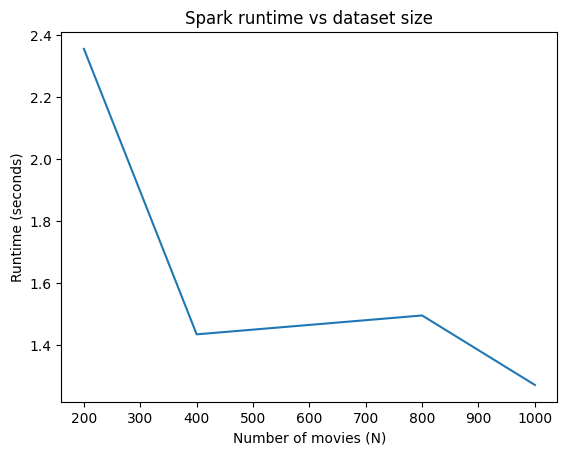

In [48]:
import matplotlib.pyplot as plt

plt.plot(res_df["N"], res_df["sec"])
plt.xlabel("Number of movies (N)")
plt.ylabel("Runtime (seconds)")
plt.title("Spark runtime vs dataset size")
plt.savefig("runtime_plot.png", dpi=200, bbox_inches="tight")
plt.show()